In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip list | grep tensorflow

tensorflow                    2.5.0              
tensorflow-datasets           4.0.1              
tensorflow-estimator          2.5.0              
tensorflow-gcs-config         2.5.0              
tensorflow-hub                0.12.0             
tensorflow-metadata           1.0.0              
tensorflow-probability        0.12.1             


In [3]:
import sys
sys.path.insert(0,'/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/unet_architecture')
sys.path.insert(0,'/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data')
from unet import unet
from helpers import display, load_data, plot_train_hist, calculateClassIOU

In [4]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import nibabel as nb
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm 
from sys import getsizeof
from tensorflow.keras.models import load_model

import nibabel as nib

In [5]:
model

NameError: ignored

In [6]:
tf.keras.backend.clear_session()
del model

NameError: ignored

In [8]:
512/4

256.0

In [ ]:
# Define constants

# Path variables
data_dir = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/'
data_dir_train_image = os.path.join(data_dir, 'complete_dataset/training/img:-1000:1000/img/')
data_dir_train_mask = os.path.join(data_dir,  'complete_dataset/training/couinaud/img/')

data_dir_test_image = os.path.join(data_dir, 'complete_dataset/testing/img:-1000:1000/img/')
data_dir_test_mask = os.path.join(data_dir, 'complete_dataset/testing/couinaud/img/')

data_dir_validate_image = os.path.join(data_dir, 'complete_dataset/validate/img:-1000:1000/img/')
data_dir_validate_mask = os.path.join(data_dir, 'complete_dataset/validate/couinaud/img/')

class_names = ['class_0','class_1','class_2','class_3',
               'class_4','class_5','class_6','class_7','class_8']

# Training variables
SEED = 7
BATCH_SIZE_TRAIN = 10
BATCH_SIZE_TEST = 10
BATCH_SIZE_VALIDATE = 10
NUM_TRAIN = 9288
NUM_TEST = 1042
NUM_VALIDATE = 1207

N_CLASSES = 6


# Image variables
IMAGE_HEIGHT = int(512/4)
IMAGE_WIDTH = int(512/4)
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)


#Original Image size
OG_IMAGE_HEIGHT = 512
OG_IMAGE_WIDTH = 512
OG_IMG_SIZE = (OG_IMAGE_HEIGHT, OG_IMAGE_WIDTH)

NUM_EPOCH = 100


In [ ]:
### Import the 'data' and save them in lists 

#Capture training image info as a list
#train_images = []
scaled_train_images = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_train_image+ '*.png')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #train_images.append(img)
  scaled_train_images.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing        
#train_images = np.array(train_images)
scaled_train_images = np.array(scaled_train_images)

print('##### TRAINING IMAGES #####')
#print(train_images.shape)
print(scaled_train_images.shape)
#print(type(train_images[0,0,0]))
##############################################################

#Capture mask/label info as a list
#train_masks = [] 
scaled_train_masks = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_train_mask + '*.tif')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #train_masks.append(img)
  other_mask_indices = img > 4
  img[other_mask_indices] = 5
  scaled_train_masks.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing      
#train_masks = np.array(train_masks)
scaled_train_masks = np.array(scaled_train_masks)

print('##### TRAINING MASKS #####') 
#print(train_masks.shape)
print(scaled_train_masks.shape)
#print(type(train_masks[0,0,0]))
##############################################################
##############################################################

#Capture testing image info as a list
#test_images = []
scaled_test_images = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_test_image+ '*.png')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #test_images.append(img)
  scaled_test_images.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing        
#test_images = np.array(test_images)
scaled_test_images = np.array(scaled_test_images)

print('##### TESTING IMAGES #####')
#print(test_images.shape)
print(scaled_test_images.shape)
#print(type(test_images[0,0,0]))
##############################################################

#Capture mask/label info as a list
#test_masks = [] 
scaled_test_masks = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_test_mask + '*.tif')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #test_masks.append(img)
  other_mask_indices = img > 4
  img[other_mask_indices] = 5
  scaled_test_masks.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing      
#test_masks = np.array(test_masks)
scaled_test_masks = np.array(scaled_test_masks)

print('##### TESTING MASKS #####') 
#print(test_masks.shape)
print(scaled_test_masks.shape)
#print(type(test_masks[0,0,0]))
##############################################################
##############################################################

#Capture validate image info as a list
#validate_images = []
scaled_validate_images = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_validate_image+ '*.png')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #validate_images.append(img)
  scaled_validate_images.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing        
#validate_images = np.array(validate_images)
scaled_validate_images = np.array(scaled_validate_images)

print('##### VALIDATE IMAGES #####')
#print(validate_images.shape)
print(scaled_validate_images.shape)
#print(type(validate_images[0,0,0]))
##############################################################

#Capture mask/label info as a list
#validate_masks = [] 
scaled_validate_masks = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_validate_mask + '*.tif')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #validate_masks.append(img)
  other_mask_indices = img > 4
  img[other_mask_indices] = 5
  scaled_validate_masks.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing      
#validate_masks = np.array(validate_masks)
scaled_validate_masks = np.array(scaled_validate_masks)

print('##### VALIDATE MASKS #####') 
#print(validate_masks.shape)
print(scaled_validate_masks.shape)
#print(type(validate_masks[0,0,0]))
##############################################################


##### TRAINING IMAGES #####
(9288, 128, 128)



##### TRAINING MASKS #####
(9288, 128, 128)



##### TESTING IMAGES #####
(1042, 128, 128)



##### TESTING MASKS #####
(1042, 128, 128)



##### VALIDATE IMAGES #####
(1207, 128, 128)



##### VALIDATE MASKS #####
(1207, 128, 128)


In [ ]:
from sklearn.utils import shuffle
scaled_train_images, scaled_train_masks = shuffle(scaled_train_images,scaled_train_masks, random_state = SEED)

In [ ]:
scaled_train_images.shape

(9288, 128, 128)

In [ ]:

round(getsizeof(scaled_train_images) / 1024 / 1024 / 1024 ,2) #to get GB 

0.14

In [ ]:
# np.unique(train_masks)

In [ ]:
# train_images = np.expand_dims(train_images, axis=3)
# test_images = np.expand_dims(test_images, axis=3)
# validate_images = np.expand_dims(validate_images, axis=3)

scaled_train_images = np.expand_dims(scaled_train_images, axis=3)
scaled_test_images = np.expand_dims(scaled_test_images, axis=3)
scaled_validate_images = np.expand_dims(scaled_validate_images, axis=3)


print('#### IMAGES ###')
# print(train_images.shape)
print(scaled_train_images.shape)
print(type(scaled_train_images[0,0,0,0]))

#print(test_images.shape)
print(scaled_test_images.shape)
print(type(scaled_test_images[0,0,0,0]))

#print(validate_images.shape)
print(scaled_validate_images.shape)
print(type(scaled_validate_images[0,0,0,0]))

##########################################################################
# train_masks = np.expand_dims(train_masks, axis=3)
# test_masks = np.expand_dims(test_masks, axis=3)
# validate_masks = np.expand_dims(validate_masks, axis=3)

scaled_train_masks = np.expand_dims(scaled_train_masks, axis=3)
scaled_test_masks = np.expand_dims(scaled_test_masks, axis=3)
scaled_validate_masks = np.expand_dims(scaled_validate_masks, axis=3)

print('#### MASKS ###')
# print(train_masks.shape)
print(scaled_train_masks.shape)

# print(test_masks.shape)
print(scaled_test_masks.shape)

# print(validate_masks.shape)
print(scaled_validate_masks.shape)

#### IMAGES ###
(9288, 128, 128, 1)
<class 'numpy.uint8'>
(1042, 128, 128, 1)
<class 'numpy.uint8'>
(1207, 128, 128, 1)
<class 'numpy.uint8'>
#### MASKS ###
(9288, 128, 128, 1)
(1042, 128, 128, 1)
(1207, 128, 128, 1)


In [ ]:
#Encode labels for all masks
scaled_train_masks = to_categorical(scaled_train_masks, num_classes=N_CLASSES)
#print(train_masks.shape)
print(scaled_train_masks.shape)

(9288, 128, 128, 6)


In [ ]:
round(getsizeof(scaled_train_images) / 1024 / 1024 / 1024 ,2) #to get GB 

0.0

In [ ]:
scaled_test_masks = to_categorical(scaled_test_masks, num_classes=N_CLASSES)
#print(test_masks.shape)
print(scaled_test_masks.shape)

(1042, 128, 128, 6)


In [ ]:
scaled_validate_masks = to_categorical(scaled_validate_masks, num_classes=N_CLASSES)
#print(validate_masks.shape)
print(scaled_validate_masks.shape)


(1207, 128, 128, 6)


In [ ]:
def display(display_list):
  plt.figure(figsize = (15,15))
  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Predicted Mask \nw/ Threshold']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'Greys_r')
  plt.show()

In [ ]:
# def show_dataset(datagen, num = 1):
#   for i in range(0, num):
#     image,mask = next(datagen)
#     display([image[0],mask[0]])


In [ ]:
 #show_dataset(train_generator, 20)

In [ ]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [ ]:
checkpoint_filepath = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/2-Models:0-4 and 0,5-8/Model1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Batches per epoch
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST
EPOCH_STEP_VALIDATE = NUM_VALIDATE // BATCH_SIZE_VALIDATE

model = unet(n_levels= 4, out_channels=6)
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [dice_coef])
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [soft_dice_loss])

In [ ]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [ ]:
history = model.fit(scaled_train_images, scaled_train_masks, 
                    batch_size = BATCH_SIZE_TRAIN, 
                    steps_per_epoch=EPOCH_STEP_TRAIN,  
                    validation_data=(scaled_validate_images, scaled_validate_masks), 
                    validation_steps=EPOCH_STEP_VALIDATE,
                    epochs = NUM_EPOCH,
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
928/928 [==============================] - 19s 19ms/step - loss: 0.4326 - accuracy: 0.9386 - val_loss: 0.0581 - val_accuracy: 0.9806
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/2-Models:0-4 and 0,5-8/Model1/assets
Epoch 2/100
928/928 [==============================] - 17s 19ms/step - loss: 0.0511 - accuracy: 0.9831 - val_loss: 0.0444 - val_accuracy: 0.9854
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/2-Models:0-4 and 0,5-8/Model1/assets
Epoch 3/100
928/928 [==============================] - 17s 19ms/step - loss: 0.0348 - accuracy: 0.9884 - val_loss: 0.0284 - val_accuracy: 0.9905
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/2-Models:0-4 and 0,5-8/Model1/assets
Epoch 4

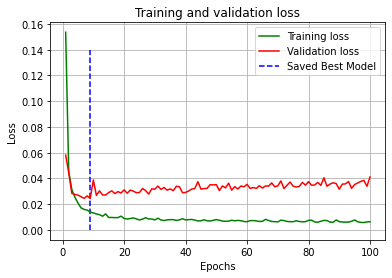

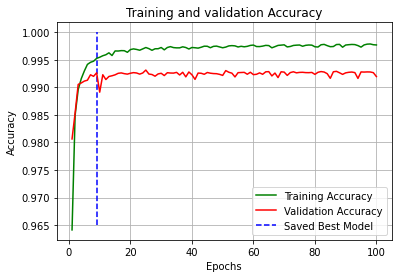

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.vlines(9, 0, 0.14, colors = 'b', linestyles = 'dashed', label='Saved Best Model') # We can see from the training history above that
                                                      # best model was saved at epoch 5
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle='-')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.vlines(9, 0.965, 1, colors = 'b', linestyles = 'dashed', label='Saved Best Model') # We can see from the training history above that
                                                      # best model was saved at epoch 5
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(linestyle='-')
plt.show()    

In [ ]:
imported_model = load_model(checkpoint_filepath)

In [ ]:
#IOU
mask_pred=model.predict(scaled_test_images)
mask_pred_argmax=np.argmax(mask_pred, axis=3) #Convert the probability into a max value within the area \

#ex: lets say we have three labels/categories
# [0,0.1,0] [0,0.05,0] [0,0.9,0] -> [0,0,0] [0,0,0] [0,1,0]

In [ ]:
#Need the test masks but no encoding for calculating IOU
test_masks_no_encode = [] 
scaled_test_masks_no_encode = []
for index, img_path in enumerate(sorted(glob.iglob(data_dir_test_mask + '*.tif'))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0) 
  other_mask_indices = img > 4
  img[other_mask_indices] = 5


  test_masks_no_encode.append(img)
  scaled_test_masks_no_encode.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing      
test_masks_no_encode = np.array(test_masks_no_encode)
scaled_test_masks_no_encode = np.array(scaled_test_masks_no_encode)

test_masks_no_encode = np.expand_dims(test_masks_no_encode, axis=3)
scaled_test_masks_no_encode = np.expand_dims(scaled_test_masks_no_encode, axis=3)

print(test_masks_no_encode.shape)
print(scaled_test_masks_no_encode.shape)

(1042, 512, 512, 1)
(1042, 128, 128, 1)


In [ ]:
from tensorflow.keras.metrics import MeanIoU
IOU = MeanIoU(num_classes=N_CLASSES)  
IOU.update_state(scaled_test_masks_no_encode[:,:,:,0], mask_pred_argmax)
print("Mean IoU =", IOU.result().numpy())

Mean IoU = 0.6632981


In [ ]:
def calculateClassIOU(cm, num_classes=9):
  #: IOU = true_positive / (true_positive + false_positive + false_negative)
  #cm: confusion matrix where rows are actual and cols are predicted 
  
  for i in range(0,num_classes):
    trueP = cm[i,i]
    falseP = 0
    falseN = 0

    for col in range(0,num_classes):
      if (i != col):
        falseP = falseP + cm[i,col]

    for row in range(0,num_classes):
      if (i != row):
        falseN = falseN + cm[row,i]

    IoU = trueP / (trueP + falseP + falseN)
    print("IoU for class,",i, " is: ", IoU)

In [ ]:
#Get confusion Matrix
values = np.array(IOU.get_weights()).reshape(N_CLASSES, N_CLASSES)
print(values)

[[1.6114817e+07 4.8880000e+03 4.4710000e+03 5.5730000e+03 1.5730000e+03
  5.5470000e+03]
 [1.2055000e+04 3.2320000e+04 2.9300000e+03 1.2200000e+03 1.1270000e+03
  4.4350000e+03]
 [6.4740000e+03 1.5250000e+03 9.0440000e+04 1.0840000e+04 4.7110000e+03
  4.2200000e+02]
 [6.4700000e+03 1.0170000e+03 8.0320000e+03 4.4863000e+04 1.8040000e+03
  3.0560000e+03]
 [4.7340000e+03 1.1520000e+03 8.4150000e+03 6.0820000e+03 6.0454000e+04
  2.1217000e+04]
 [1.0836000e+04 2.4910000e+03 4.1500000e+02 1.5180000e+03 2.2114000e+04
  5.6209000e+05]]


In [ ]:
#To calculate I0U for each class...
calculateClassIOU(values, N_CLASSES)

IoU for class, 0  is:  0.9961291151293549
IoU for class, 1  is:  0.4960098219766728
IoU for class, 2  is:  0.6521723454119344
IoU for class, 3  is:  0.4958607350096712
IoU for class, 4  is:  0.45323616952685125
IoU for class, 5  is:  0.8863801583559492


Instance in test dataset:  0


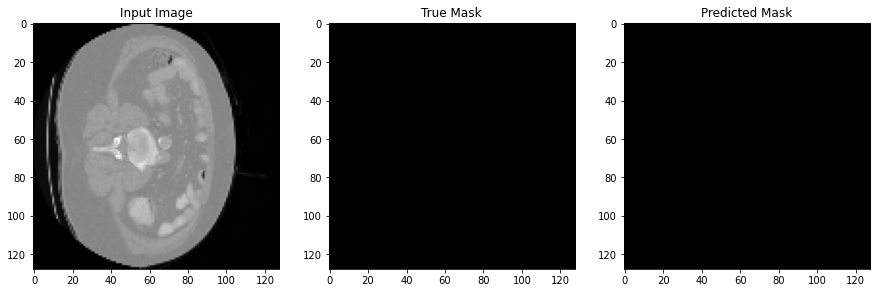

Instance in test dataset:  1


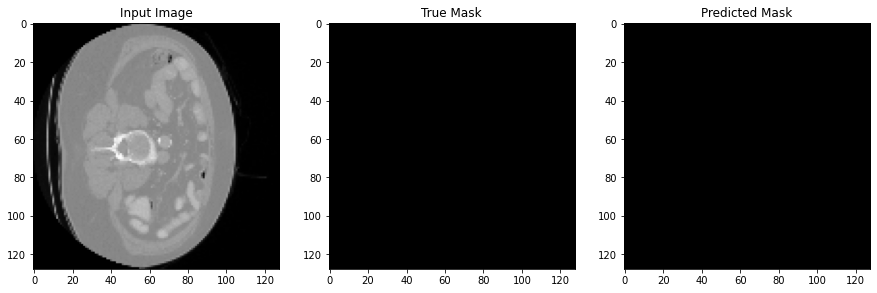

Instance in test dataset:  2


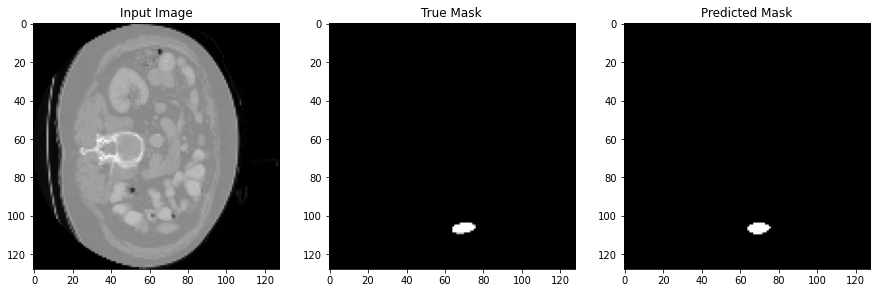

Instance in test dataset:  3


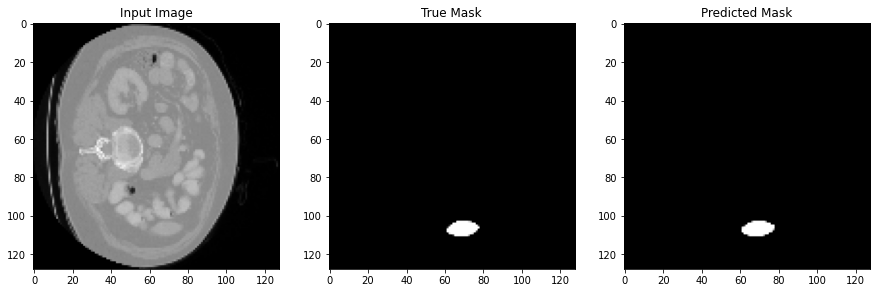

Instance in test dataset:  4


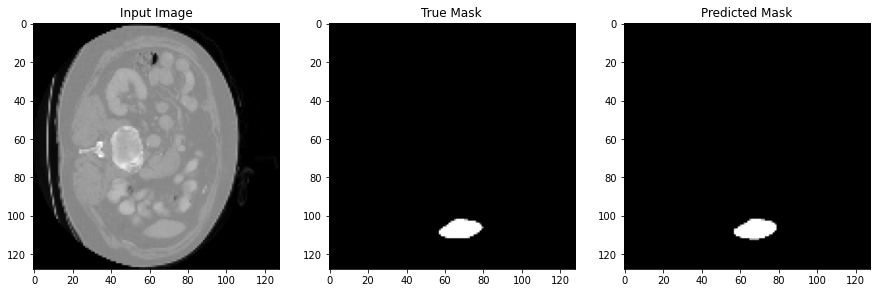

Instance in test dataset:  5


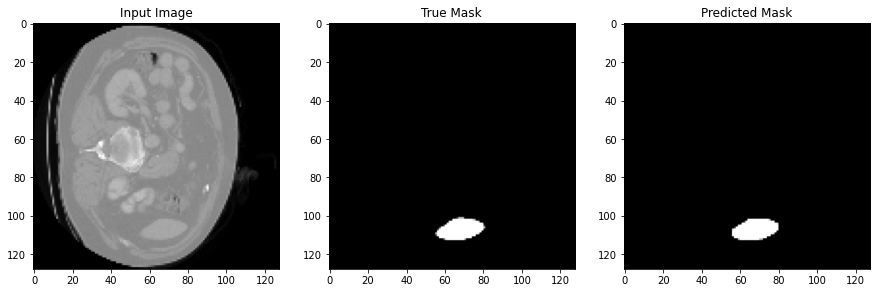

Instance in test dataset:  6


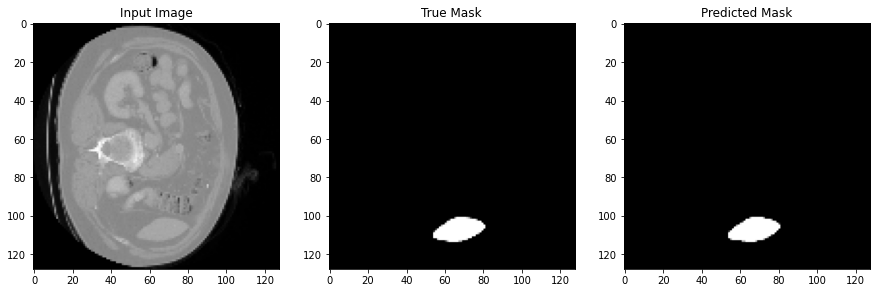

Instance in test dataset:  7


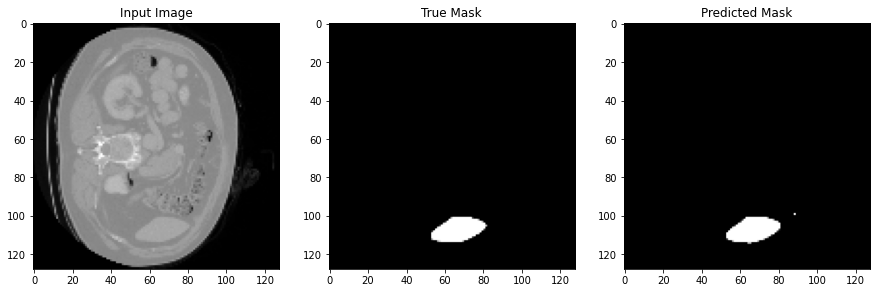

Instance in test dataset:  8


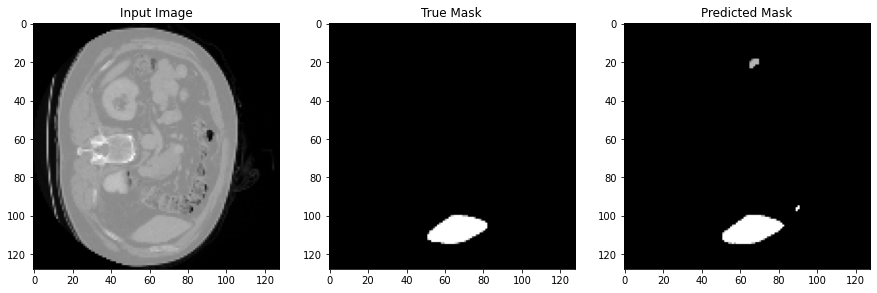

Instance in test dataset:  9


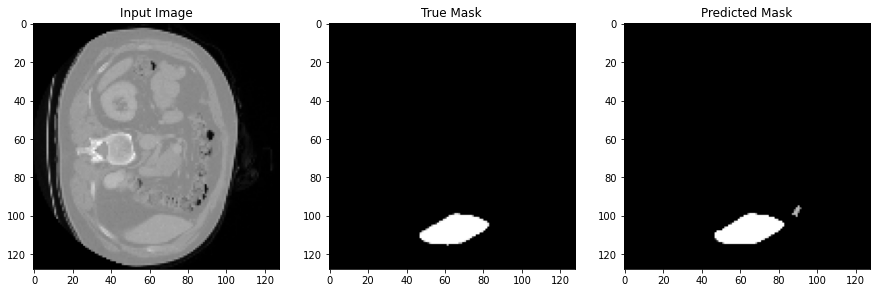

Instance in test dataset:  10


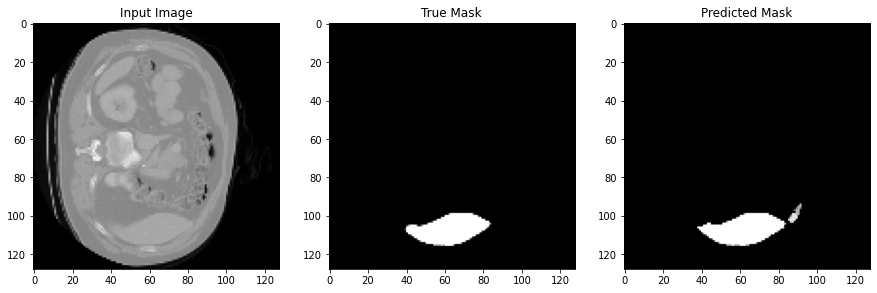

Instance in test dataset:  11


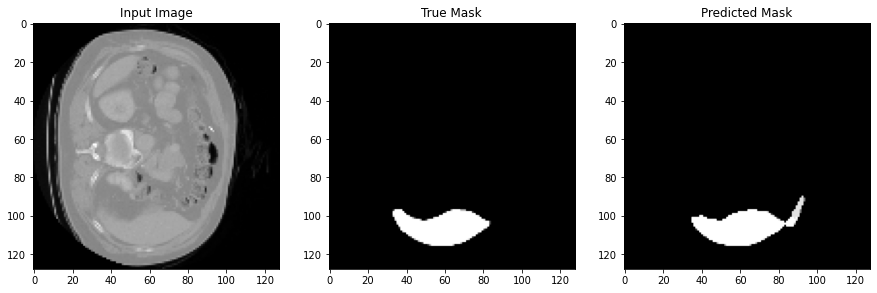

Instance in test dataset:  12


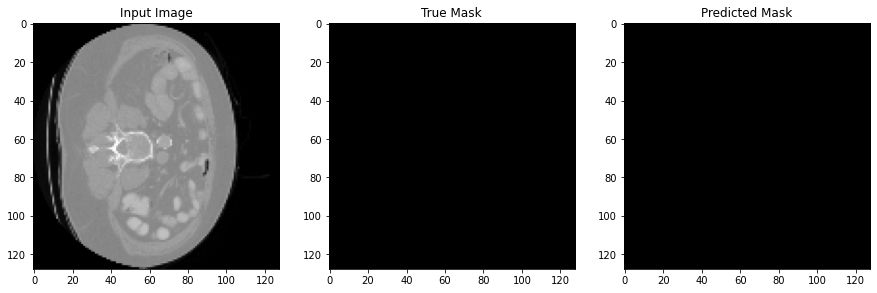

Instance in test dataset:  13


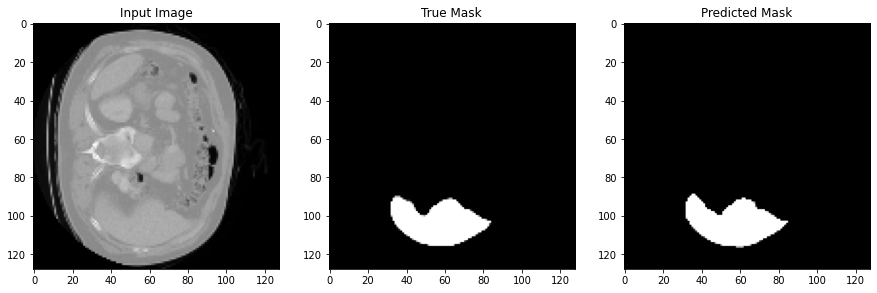

Instance in test dataset:  14


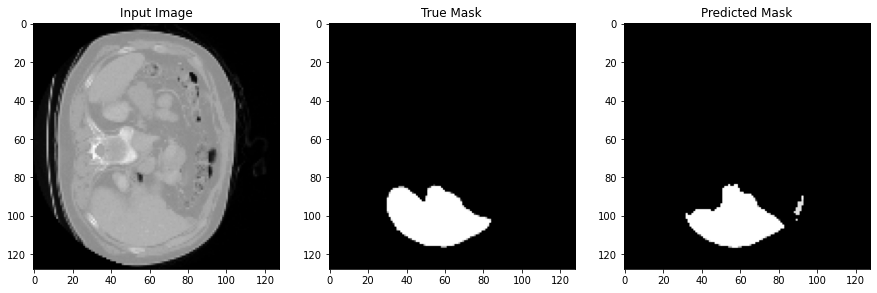

Instance in test dataset:  15


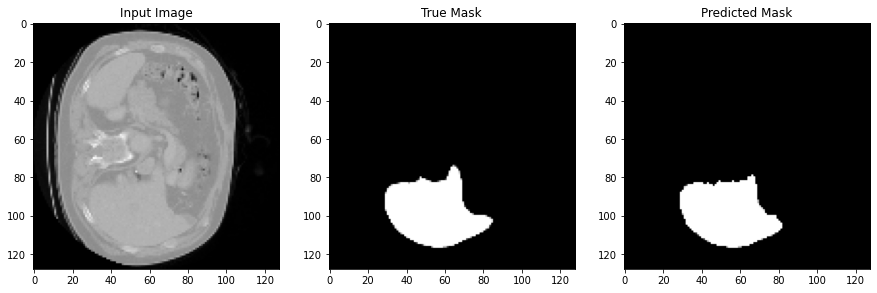

Instance in test dataset:  16


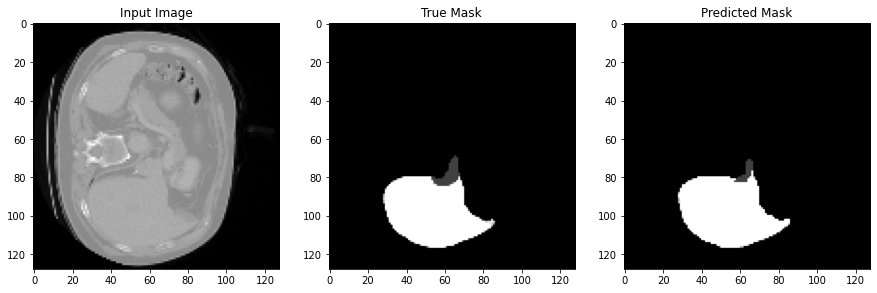

Instance in test dataset:  17


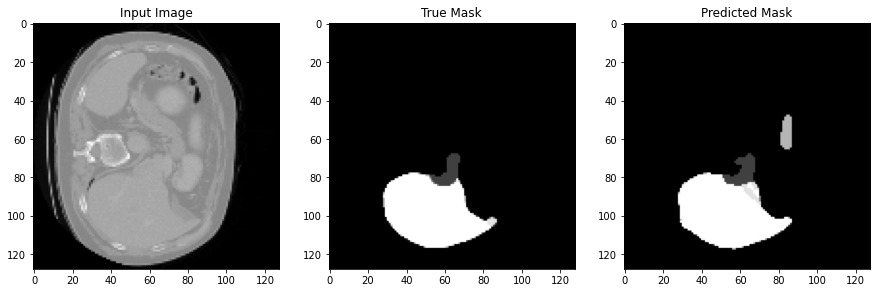

Instance in test dataset:  18


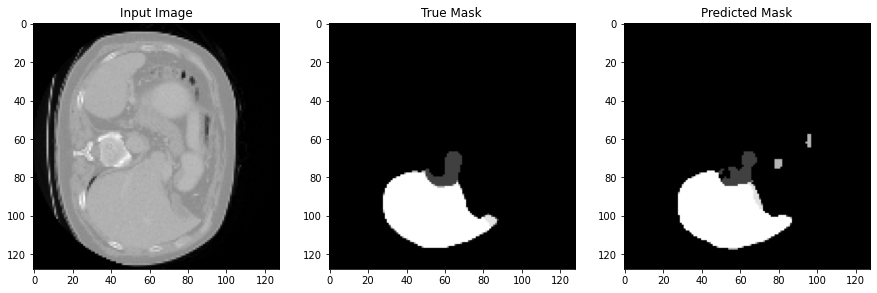

Instance in test dataset:  19


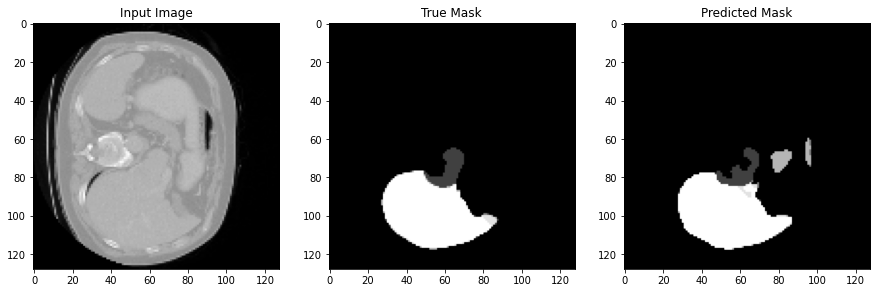

Instance in test dataset:  20


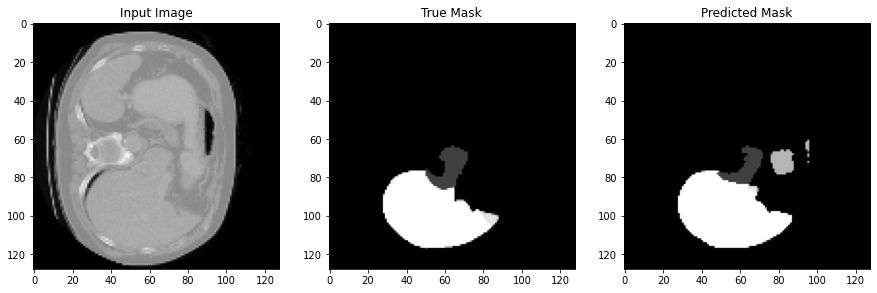

Instance in test dataset:  21


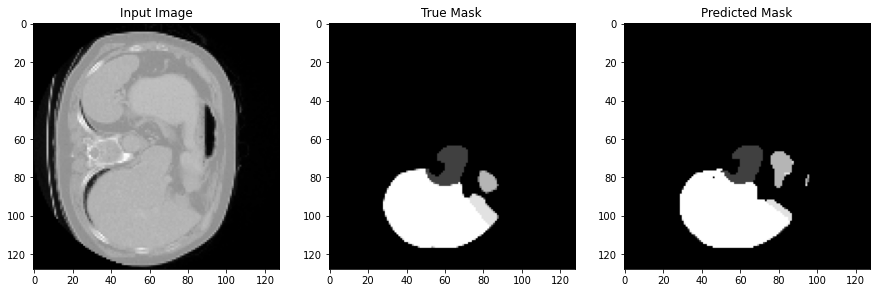

Instance in test dataset:  22


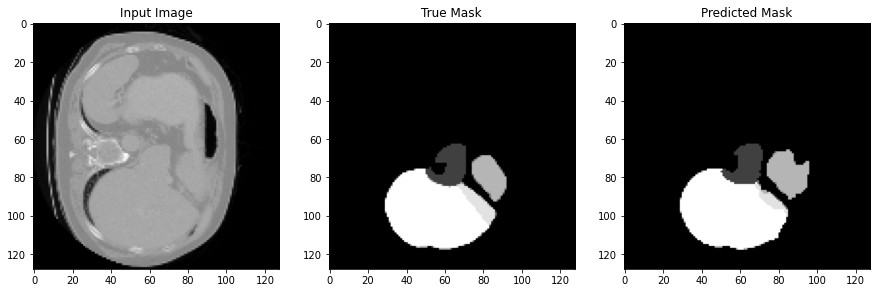

Instance in test dataset:  23


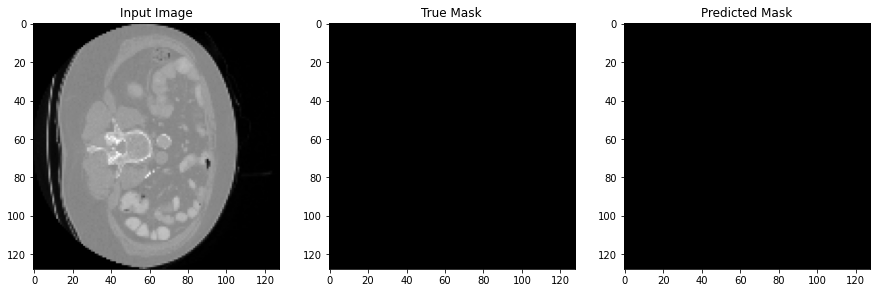

Instance in test dataset:  24


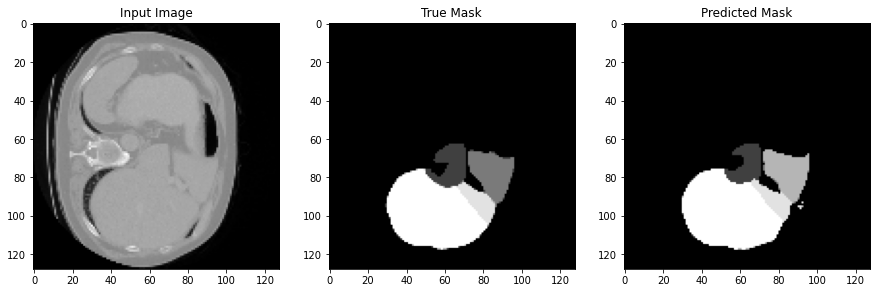

Instance in test dataset:  25


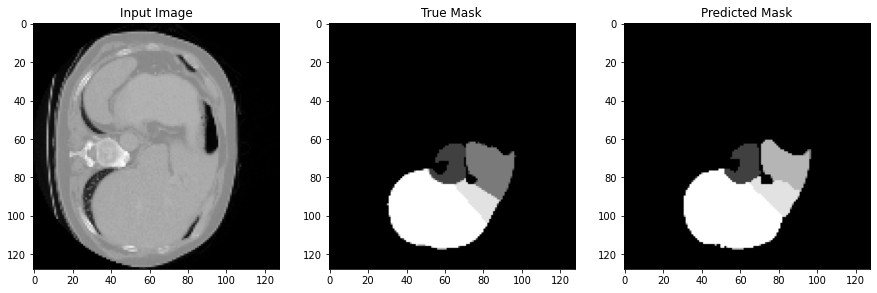

Instance in test dataset:  26


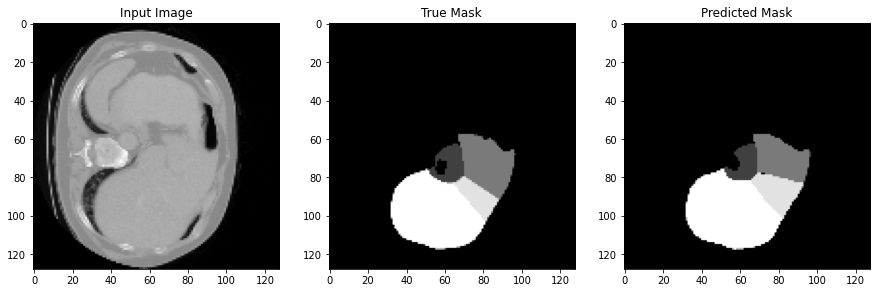

Instance in test dataset:  27


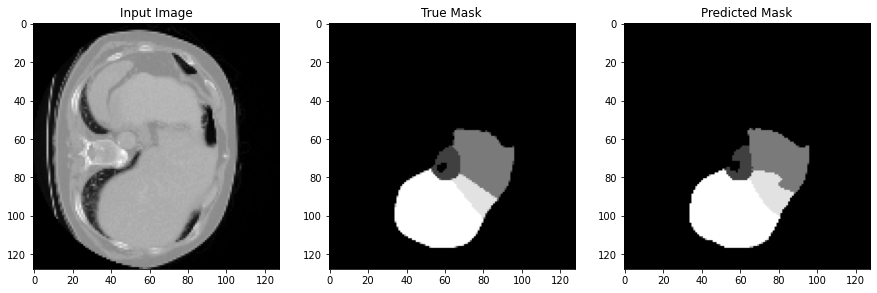

Instance in test dataset:  28


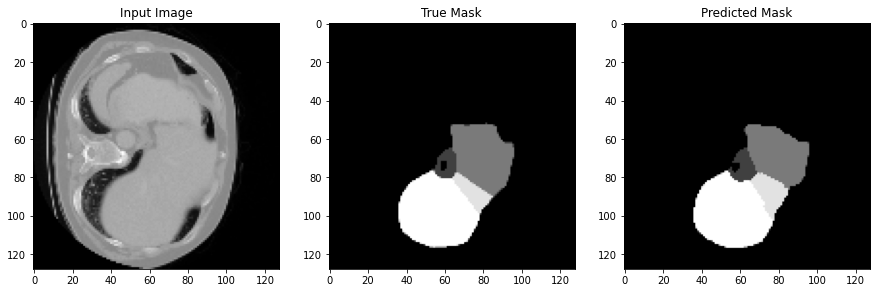

Instance in test dataset:  29


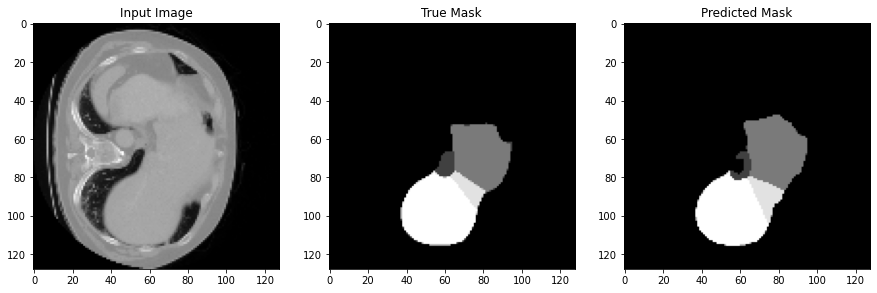

Instance in test dataset:  30


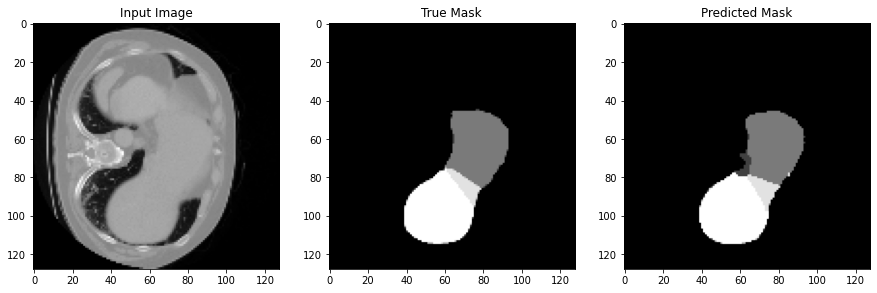

Instance in test dataset:  31


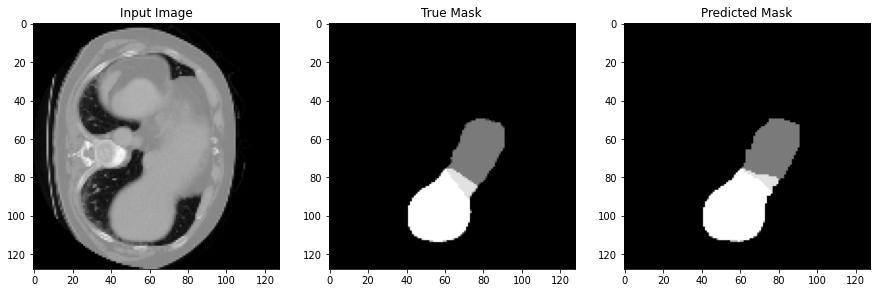

Instance in test dataset:  32


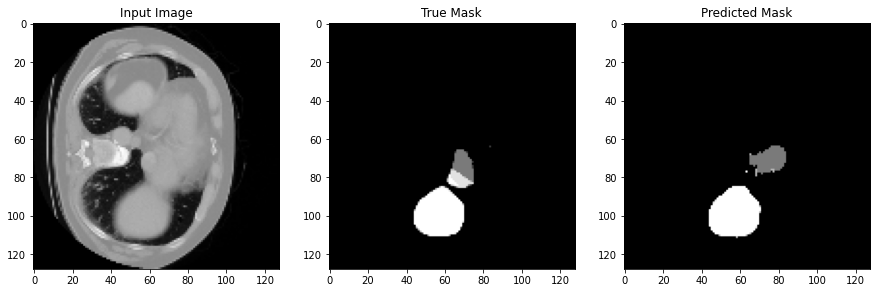

Instance in test dataset:  33


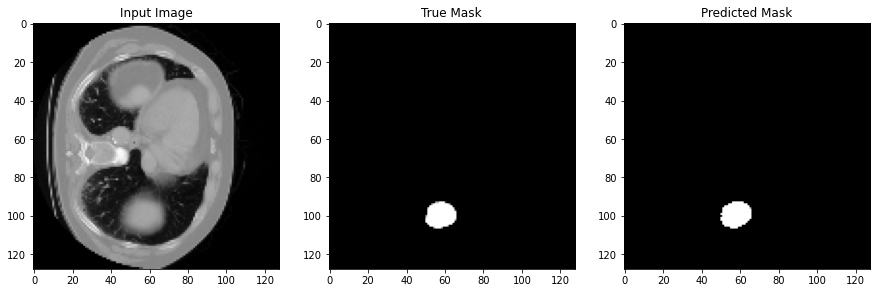

Instance in test dataset:  34


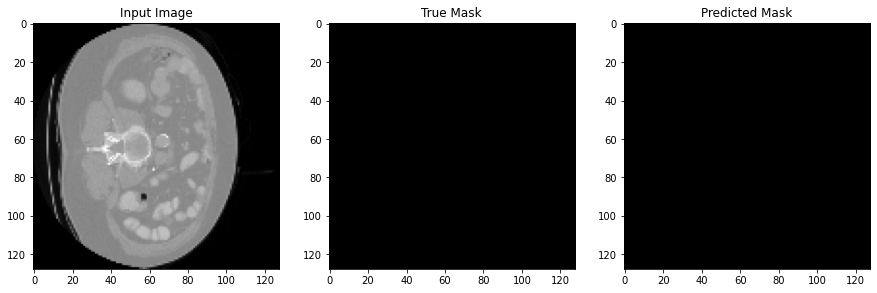

Instance in test dataset:  35


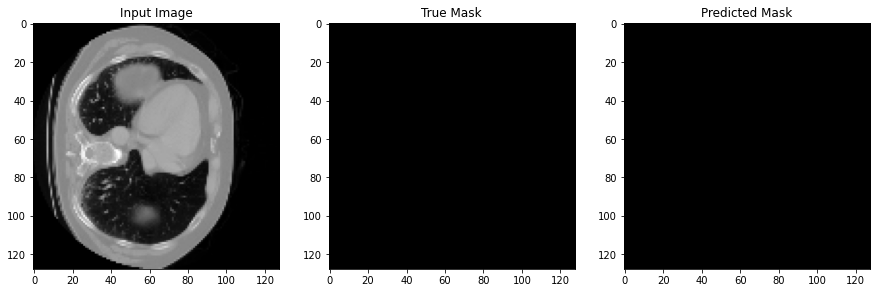

Instance in test dataset:  36


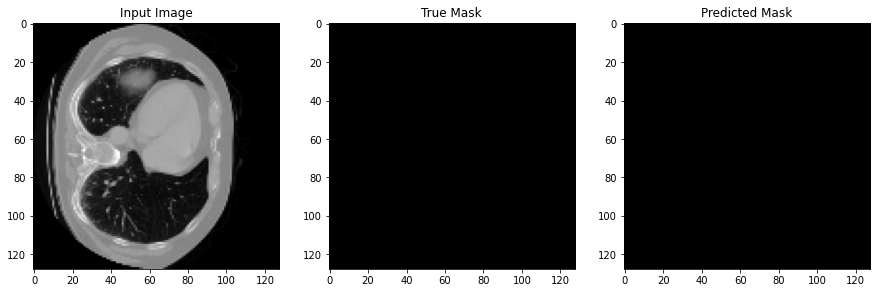

Instance in test dataset:  37


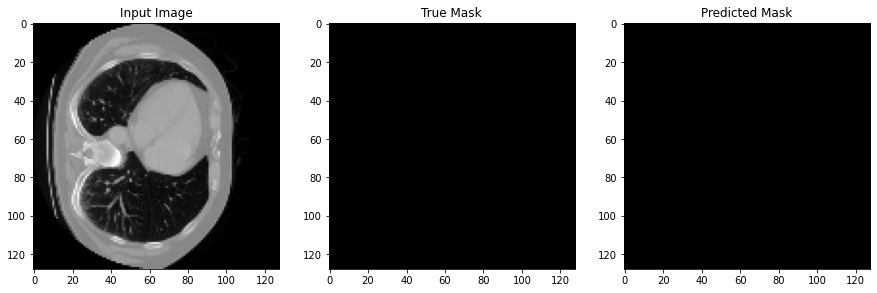

Instance in test dataset:  38


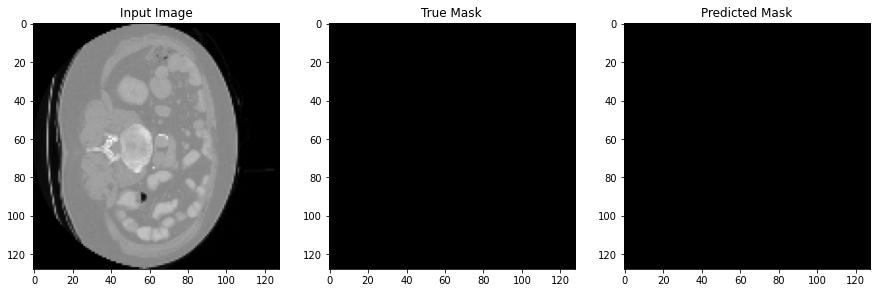

Instance in test dataset:  39


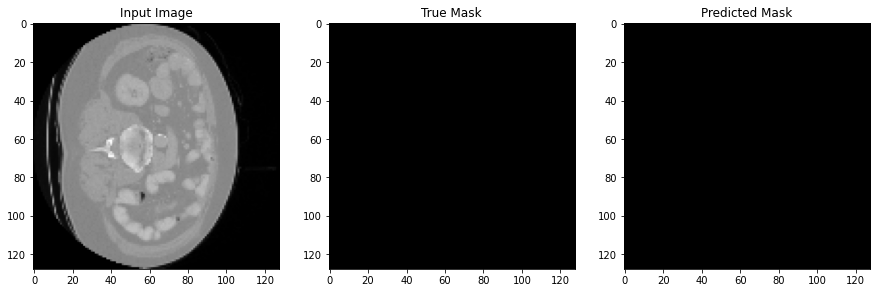

Instance in test dataset:  40


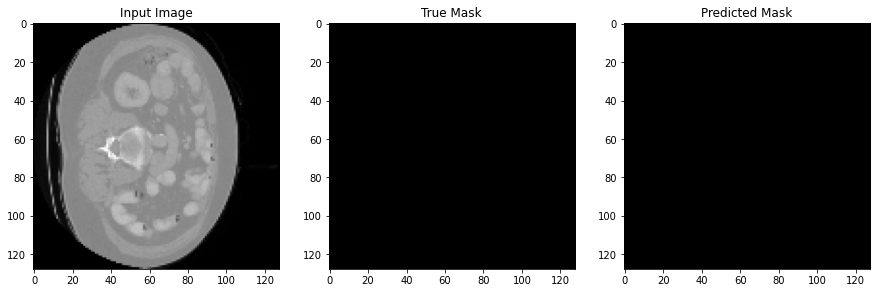

Instance in test dataset:  41


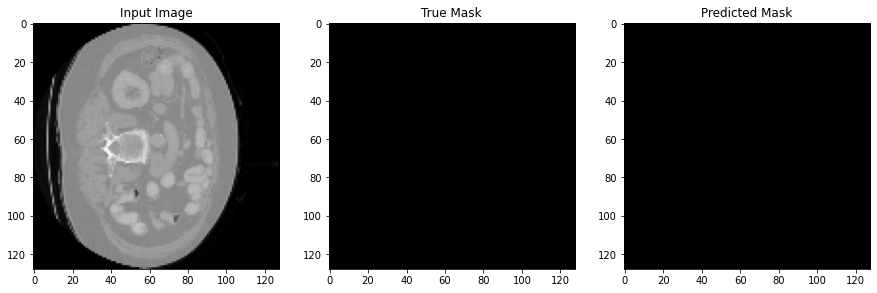

Instance in test dataset:  42


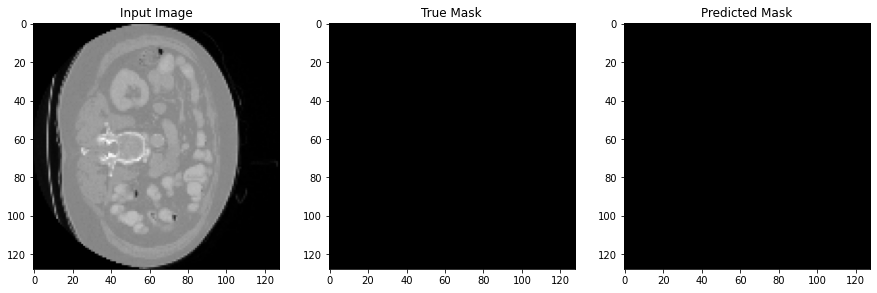

Instance in test dataset:  43


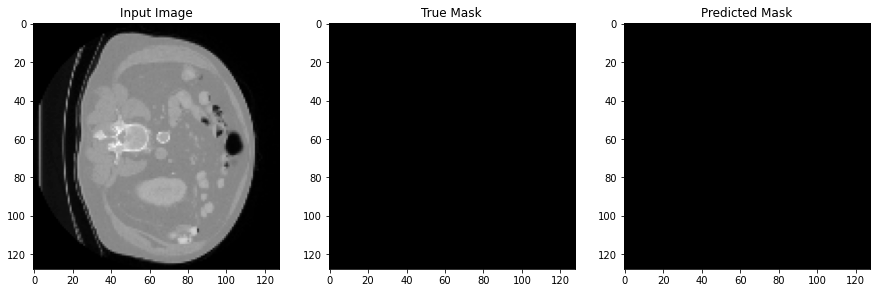

Instance in test dataset:  44


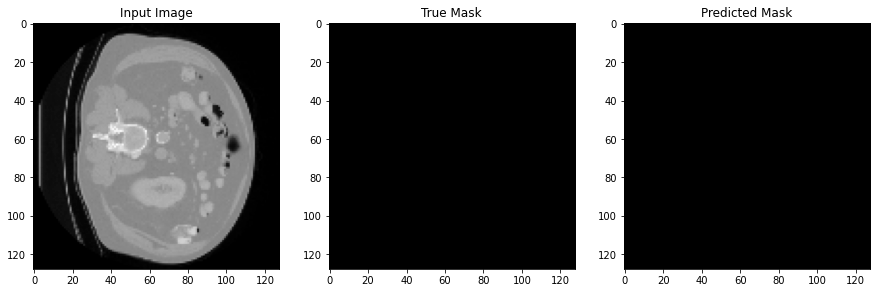

Instance in test dataset:  45


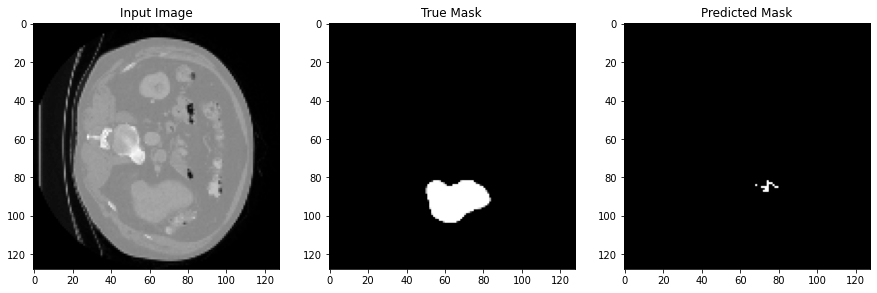

Instance in test dataset:  46


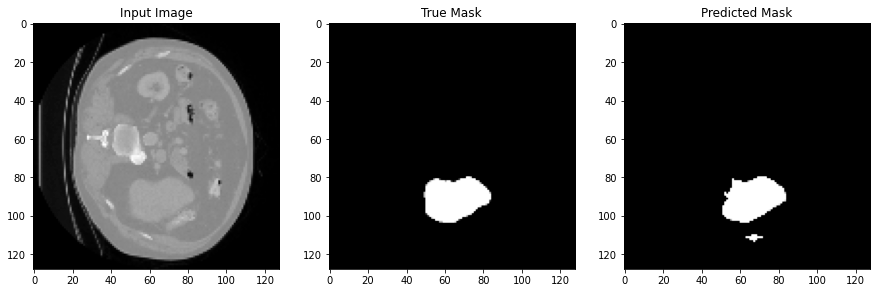

Instance in test dataset:  47


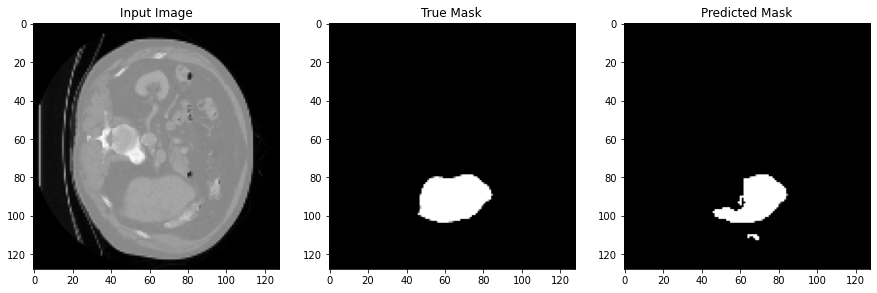

Instance in test dataset:  48


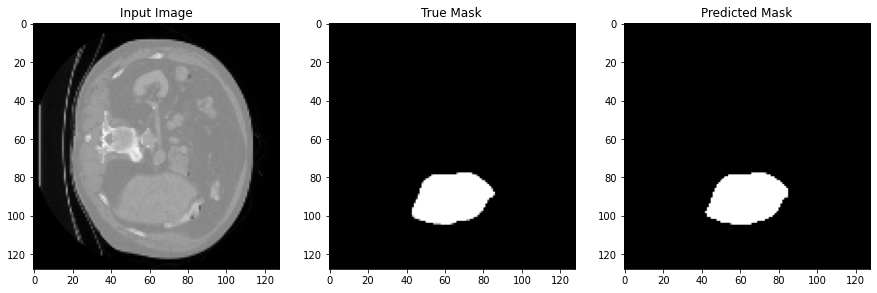

Instance in test dataset:  49


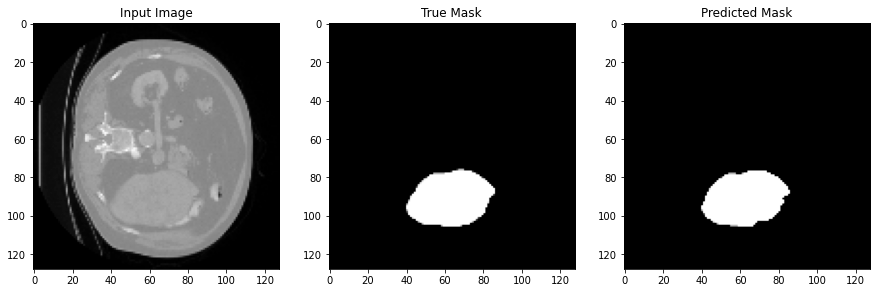

In [ ]:
for i in range(0,50):
  print("Instance in test dataset: ", i)
  display([scaled_test_images[i], scaled_test_masks_no_encode[i], np.expand_dims(mask_pred_argmax[i], axis=2)])
  print("==================================================================================================================")

In [ ]:
for i in range(0,50):
  print("Instance in test dataset: ", i)
  display([scaled_test_images[i], scaled_test_masks_no_encode[i], np.expand_dims(mask_pred_argmax[i], axis=2)])
  mask_pred_argmaxOGSHAPE = cv2.resize(mask_pred_argmax[i].astype('float32')  , OG_IMG_SIZE, interpolation = cv2.INTER_LINEAR)
  display([np.expand_dims(test_images[i], axis=2), test_masks_no_encode[i], np.expand_dims(mask_pred_argmaxOGSHAPE, axis=2)])
  print("==================================================================================================================")

In [ ]:
tf.keras.backend.clear_session()
del model
del model2 
del imported_model

In [ ]:
tf.keras.backend.clear_session()
del imported_model